In [1]:
import numpy as np

from torch import nn
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')

import corner 

from time import time
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib import rcParams
rcParams.update({'font.size': 12})

import gc

dtype = torch.float

# Setting the seed
torch.manual_seed(42)
import random
random.seed(42)
np.random.seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.set_default_dtype(torch.float64)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [2]:
import sys
sys.path.insert(1, '/home/dbreitman/Radio_Background/Models/Final_model/')
from ml import Radio_Emulator

In [3]:
path = '/home/dbreitman/Radio_Background/Models/Final_model/'

In [4]:
# Calculate fractional error (FE)
def print_fe(pred, true, name="", ret = False, floor = None):
    if floor is not None:
        m = abs(true) < floor
        true_final = true.copy()
        true_final[m] = floor
    else:
        true_final = true

    frac_err = abs((pred - true) / true_final) * 100.
    print('FE (%) ' + name + ': Median: %.4f, 68%%CI: %.4f, 95%%CI: %.4f'% tuple(np.nanpercentile(frac_err, [50,84,97.5])))
    print('Abs diff ' + name + ': Median: %.5f, 68%%CI: %.5f, 95%%CI: %.5f'% tuple(np.nanpercentile(abs(pred-true), [50,84,97.5])))
   
    print('FE ' + name + ' STD: %.3f' %np.nanstd(frac_err) )
    if ret:
        return frac_err

def get_prediction(y_pred):
    csts = np.load(path+'Feb_wPScsts.npz')
    l = len(global_z)
    Tb_pred = -10**((torch.Tensor(y_pred[:,:l] * csts['Tb_std']) + csts['Tb_mean'])) + csts['Tb_scale']
    
    Tr_pred = 10**(torch.Tensor(y_pred[:,l:2*l] * csts['logTr_std']) + csts['logTr_mean'])
        
    xHI_out  = torch.Tensor(y_pred[:,2*l:3*l])
    m = xHI_out < 1e-4
    xHI_pred = torch.clone(xHI_out)
    xHI_pred[m] = 1e-4
    
    PS_pred = 10**(torch.Tensor(y_pred[:,3*l:-1].reshape((y_pred.shape[0],len(ps_z), len(ps_k))) * csts['logPS_std']) + csts['logPS_mean'])
        
    tau_pred = 10**(torch.Tensor(y_pred[:,-1]))
    
    return Tb_pred.detach().cpu().numpy()[:,::-1], Tr_pred.detach().cpu().numpy()[:,::-1], xHI_pred.detach().cpu().numpy()[:,::-1], PS_pred.detach().cpu().numpy(), tau_pred.detach().cpu().numpy()


In [5]:
model = Radio_Emulator()

In [108]:
model.load_state_dict(torch.load(path+'FINAL_EMULATOR'))
model.eval()

Radio_Emulator(
  (Tb_branch): Sequential(
    (0): Linear(in_features=5, out_features=1500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (4): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (5): Sequential(
        (0): Linear(in_features=1500, out_features=1500, bias=True)
        (1): LeakyReLU(negati

In [5]:
ps_file = np.load('../../PS_Summaries.npz')
ps = ps_file['PS_Summaries'] #Delta^2 in mK^2
ps_z = ps_file['z_axis']
ps_k = ps_file['k_axis'][0] #Mpc^{-1}
print(ps_k[0], ps_k[-1])
ps_params = ps_file['params']

globalsums = np.load('../../Global_Summaries.npz')
Tbs = globalsums['Tb_axis']
Trs = globalsums['Tr_axis']
#Tks = globalsums['Tk_axis']
xHIs = globalsums['xH_axis']
taus = globalsums['tau_axis']
params = globalsums['params_axis']
global_z = globalsums['z_axis']
redshifts = global_z
zs = global_z

labels = [r'log$_{10}$ f$_{\rm R,mini}$', 
          r'log$_{10}$L$_{\rm X, mini}$',
          r'log$_{10}$F$_{\ast,mini}$',
    r'log$_{10}$F$_{\rm esc, mini}$',
    r'A$_{\rm LW}$']
print(params.shape)

0.013808050919982587 0.4952083787163125
(122543, 5)


In [8]:
np.all(ps_params == params)

True

In [9]:
m = Tbs < -10000
crazy = np.any(m, axis = 1)

# Remove the crazy ones
params = params[~crazy]
Tbs = Tbs[~crazy]
Trs = Trs[~crazy]
xHIs = xHIs[~crazy]
taus = taus[~crazy]
ps = ps[~crazy]
#Tks = Tks[~crazy]

In [10]:
#Input into emulator is \in [0,1] for all the parameters so they need to be rescaled:
limits = np.array([[-2, 6], [33, 45], [-5, 0], [-6, -1], [0, 10]])
normed_params = (params - limits[:,0])/(limits[:,1] - limits[:,0])

In [11]:
f_train = 0.8
f_test = 0.1
f_valid = 1 - f_train - f_test
idx_train = int(np.round(params.shape[0] * f_train))
idx_valid = idx_train + int(np.round(params.shape[0] * f_valid))

output_db = np.zeros((params.shape[0], len(redshifts) * 3 + len(ps_z)*len(ps_k) + 1))
output_db[:, :len(redshifts)] = Tbs
output_db[:, len(redshifts):2*len(redshifts)] = Trs
output_db[:, 2*len(redshifts):3*len(redshifts)] = xHIs
output_db[:, 3*len(redshifts):-1] = ps.reshape((ps.shape[0],  len(ps_z)*len(ps_k)))
#output_db[:, 3*len(redshifts):4*len(redshifts)] = normed_logTk
output_db[:, -1] = taus


# Shuffle because the final params are all ~the same...
idxs = np.load(path+'Feb_wPSidxs_wlogps.npy')
#idxs = np.arange(output_db.shape[0]) w seed 42
#np.random.shuffle(idxs)

Y_test = output_db[idxs][idx_valid:]

X_test = normed_params[idxs][idx_valid:]

print(Y_test.shape)

(12147, 810)


In [12]:
print(idxs)
# Should be array([ 96051  27568  47569 ... 103694    860  15795]) if seed is fixed to 42

[ 96051  27568  47569 ... 103694    860  15795]


In [207]:
Tb_pred, Tr_pred, xHI_pred, PS_pred, tau_pred = get_prediction(model(torch.Tensor(X_test).to(device)).detach().cpu().numpy())

In [210]:
Tb_true = Y_test[:, :len(redshifts)][:,::-1]
Tr_true = Y_test[:, len(redshifts):2*len(redshifts)][:,::-1] 
xHI_true = Y_test[:, 2*len(redshifts):3*len(redshifts)][:,::-1]
PS_true = Y_test[:, 3*len(redshifts):-1].reshape((Y_test.shape[0], len(ps_z), len(ps_k)))
m = PS_true < 1e-2
PS_true[m] = 1e-2
tau_true = Y_test[:, -1]

In [211]:
# print performance
Tb_frac_err = print_fe(Tb_pred, Tb_true, name="Tb", ret=True, floor = 5)

FE (%) Tb: Median: 2.4762, 68%CI: 9.1523, 95%CI: 28.8986
Abs diff Tb: Median: 0.46673, 68%CI: 2.96137, 95%CI: 14.35107
FE Tb STD: 21.169


In [212]:
Tr_frac_err = print_fe(Tr_pred, Tr_true, name = "Tr", ret = True, floor = 1e-4)

FE (%) Tr: Median: 1.3031, 68%CI: 4.6830, 95%CI: 99.9876
Abs diff Tr: Median: 0.78199, 68%CI: 8.91714, 95%CI: 33.78122
FE Tr STD: 22.921


In [213]:
xHI_frac_err = print_fe(xHI_pred, xHI_true, name = "xHI", ret = True, floor = 1e-3)

FE (%) xHI: Median: 0.2443, 68%CI: 11.3285, 95%CI: 69.5667
Abs diff xHI: Median: 0.00030, 68%CI: 0.00157, 95%CI: 0.00783
FE xHI STD: 72.146


In [214]:
PS_frac_err = print_fe(PS_pred, PS_true, name = "PS", ret = True, floor = 1e-2)

FE (%) PS: Median: 3.4465, 68%CI: 17.7863, 95%CI: 68.5842
Abs diff PS: Median: 0.03658, 68%CI: 26.55821, 95%CI: 6962.06352
FE PS STD: 80.086


In [215]:
tau_frac_err = print_fe(tau_pred, tau_true, name = "tau", ret = True)

FE (%) tau: Median: 0.2742, 68%CI: 0.7080, 95%CI: 1.7215
Abs diff tau: Median: 0.00031, 68%CI: 0.00084, 95%CI: 0.00231
FE tau STD: 0.518


In [74]:
with h5py.File('/projects/cosmo_database/dprelogovic/database/seed_90655.h5') as f:
    print(f['lightcones']['brightness_temp'])

<HDF5 dataset "brightness_temp": shape (200, 200, 2553), type "<f4">


In [226]:
np.savez(path+'median_test_errors', PS_err = np.median(PS_diff, axis = 0),
         Tb_err = np.median(Tb_diff, axis = 0),
         xHI_err = np.median(xHI_diff, axis = 0),
         Tr_err = np.median(Tr_diff, axis = 0),
         tau_err = np.median(tau_diff, axis = 0))

In [30]:
# Make some plots

In [225]:
xHI_diff = abs((xHI_pred - xHI_true))
diff_err_xHI_z = np.nanpercentile(xHI_diff, [2.5, 16,50, 84, 97.5], axis = 0)

PS_diff = abs((PS_pred - PS_true))
diff_err_PS_z = np.nanpercentile(PS_diff, [2.5, 16,50, 84, 97.5], axis = 0)

Tb_diff = abs((Tb_pred - Tb_true))
diff_err_Tb_z = np.nanpercentile(Tb_diff, [2.5, 16,50, 84, 97.5], axis = 0)

Tr_diff = abs((Tr_pred - Tr_true))
diff_err_Tr_z = np.nanpercentile(Tr_diff, [2.5, 16,50, 84, 97.5], axis = 0)

tau_diff = abs((tau_pred - tau_true))

In [198]:
idxs = np.arange(tau_pred.shape[0])
np.random.shuffle(idxs)

In [199]:
N = 10
idxs = idxs[:N]

In [218]:
cs = ['r', 'g', 'b', 'lime', 'cyan', 'orange', 'k', 'tan', 'firebrick', 'magenta']

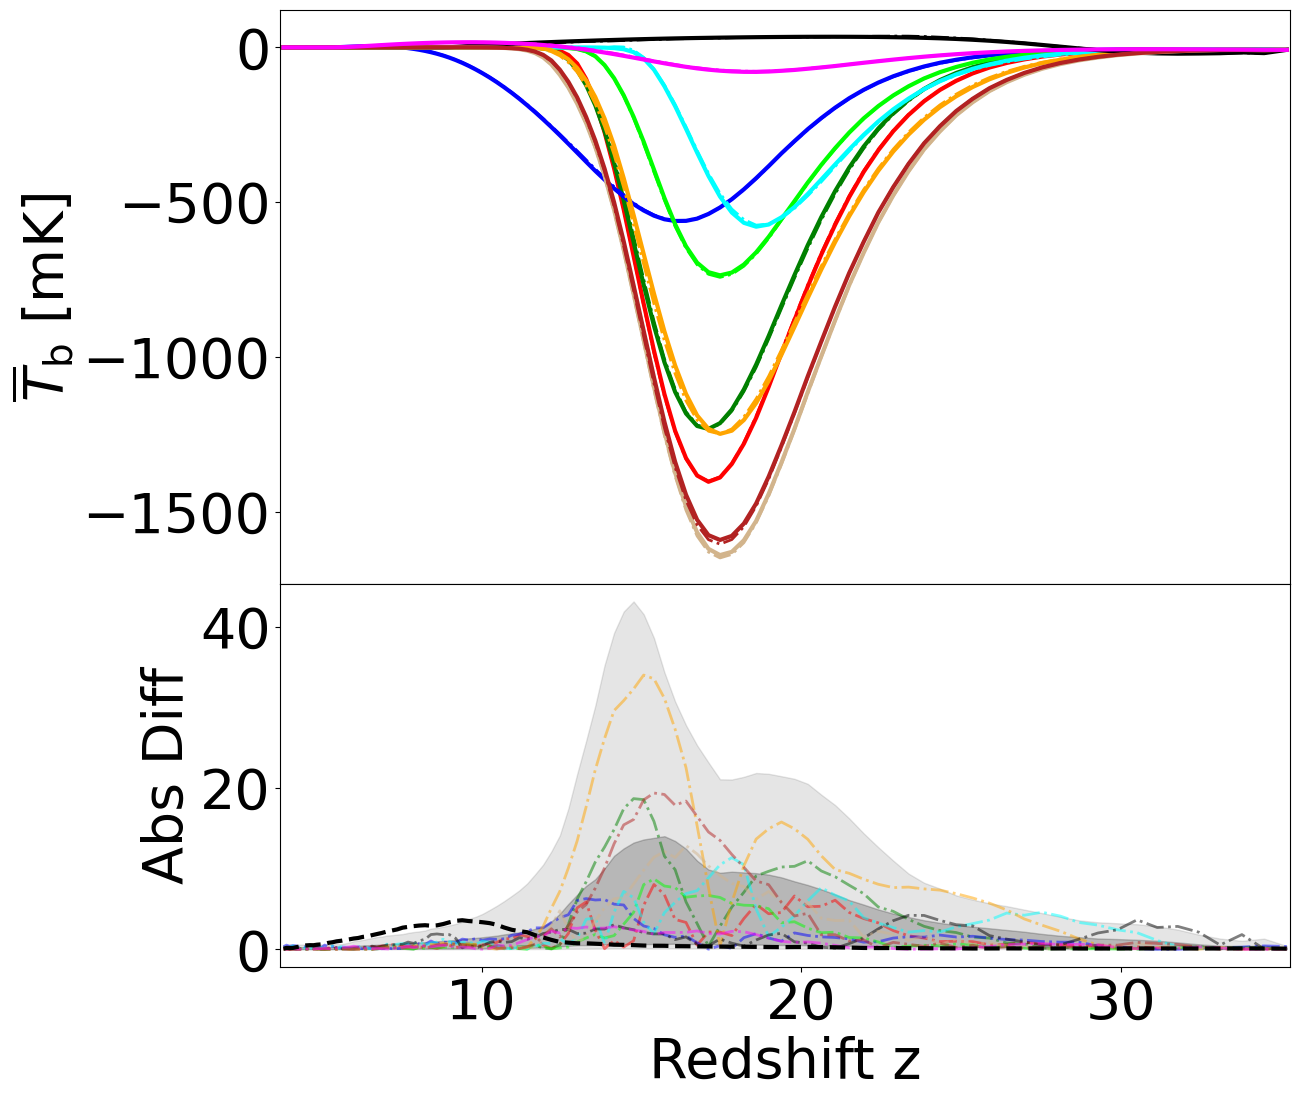

In [219]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

# inset axes...
#axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c in zip(idxs, cs):
    if i == N-1:
        labels = ['21cmEMU', 'Test Set']
    else:
        labels = [None, None]
    axs[0].plot(zs, Tb_true[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, Tb_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, Tb_pred[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[1].plot(zs, diff_err_Tb_z[2, :][::-1], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_Tb_z[1, :], diff_err_Tb_z[3, :], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_Tb_z[0, :], diff_err_Tb_z[4, :], color = 'k', alpha = 0.1, label = r'95% CI')


axs[0].set_ylabel(r'$\overline{T}_{\rm{b}}$ [mK]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')
axs[1].tick_params(axis='both', which='major')
axs[1].tick_params(axis='both', which='minor')
axs[0].tick_params(axis='y', which='major')
axs[0].tick_params(axis='y', which='minor')
axs[0].set_xlim(zs[0]-0.1, zs[-1]+0.1)
#axs[0].set_xlim(zs[0], zs[-1])
#axins.set_ylim(-1e-5, 1e-2)
#axins.set_ylabel(r'$| \overline{T}_{b, \mathrm{ true}} - \overline{T}_{b, \mathrm{ 21cmEMU}} |$ [mK]', fontsize = 18)
#axins.set_xlabel(r'Redshift z', fontsize = 18)

plt.tight_layout()
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/Tb_true_vs_emu_final_zcut.png', dpi = 300, bbox_inches='tight')
plt.show()

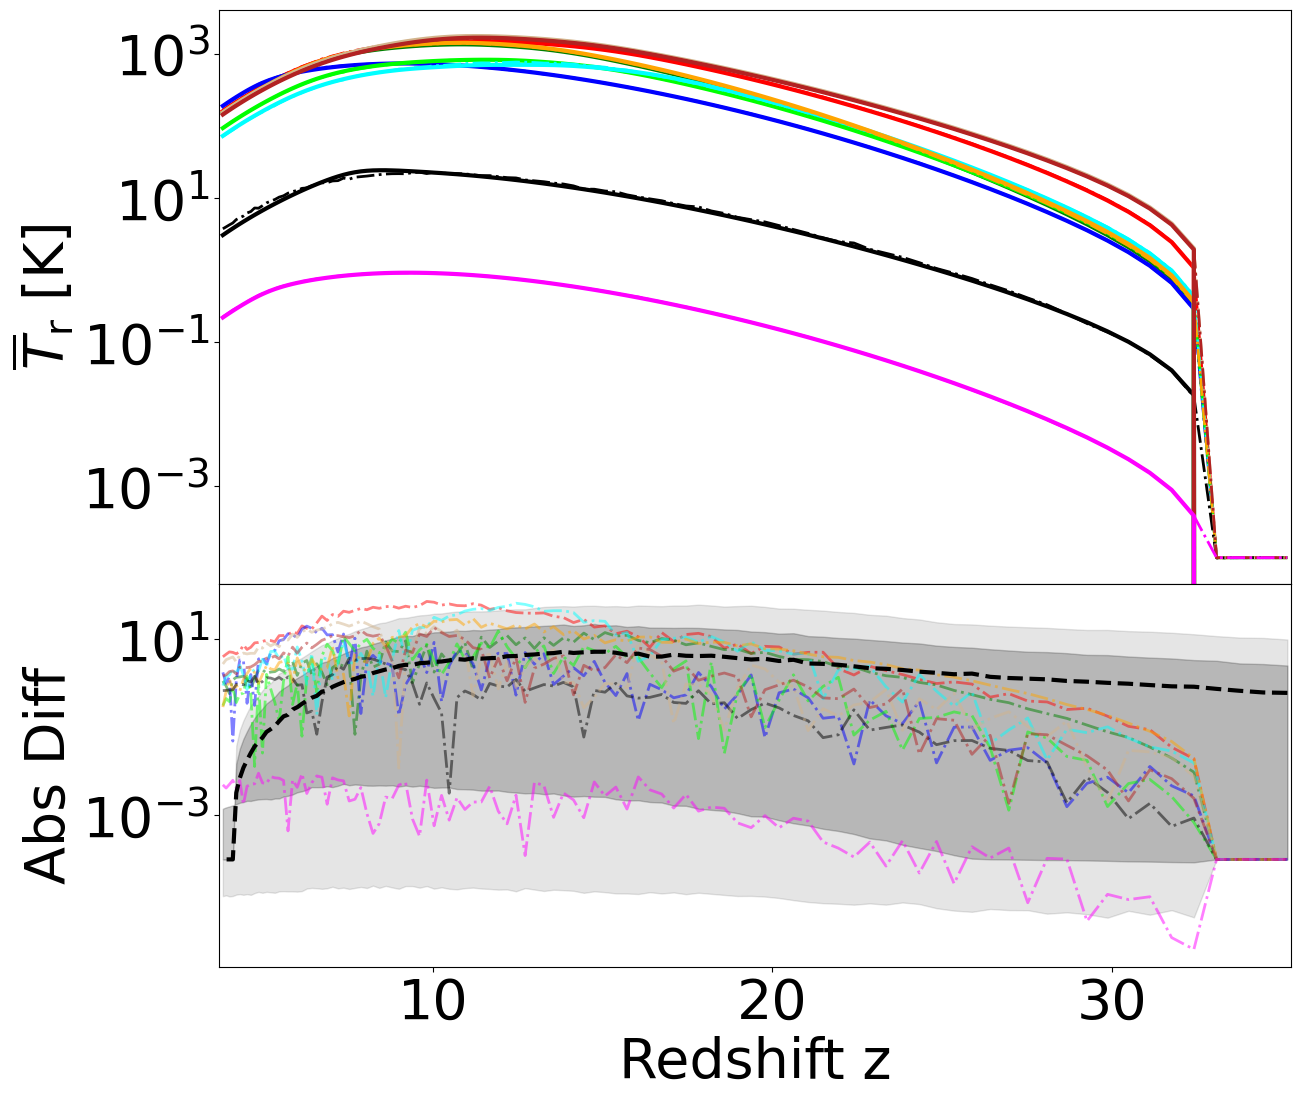

In [220]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

# inset axes...
#axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c in zip(idxs, cs):
    if i == N-1:
        labels = ['21cmEMU', 'Test Set']
    else:
        labels = [None, None]
    axs[0].plot(zs, Tr_true[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, Tr_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, Tr_pred[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[1].plot(zs[::-1], diff_err_Tr_z[2, :], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_Tr_z[1, :], diff_err_Tr_z[3, :][::-1], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_Tr_z[0, :], diff_err_Tr_z[4, :][::-1], color = 'k', alpha = 0.1, label = r'95% CI')


axs[0].set_ylabel(r'$\overline{T}_{\rm{r}}$ [K]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')
axs[1].tick_params(axis='both', which='major')
axs[1].tick_params(axis='both', which='minor')
axs[0].tick_params(axis='y', which='major')
axs[0].tick_params(axis='y', which='minor')
axs[0].set_xlim(zs[0]-0.1, zs[-1]+0.1)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
#axs[0].set_xlim(zs[0], zs[-1])
#axins.set_ylim(-1e-5, 1e-2)
#axins.set_ylabel(r'$| \overline{T}_{b, \mathrm{ true}} - \overline{T}_{b, \mathrm{ 21cmEMU}} |$ [mK]', fontsize = 18)
#axins.set_xlabel(r'Redshift z', fontsize = 18)

plt.tight_layout()
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/Tb_true_vs_emu_final_zcut.png', dpi = 300, bbox_inches='tight')
plt.show()

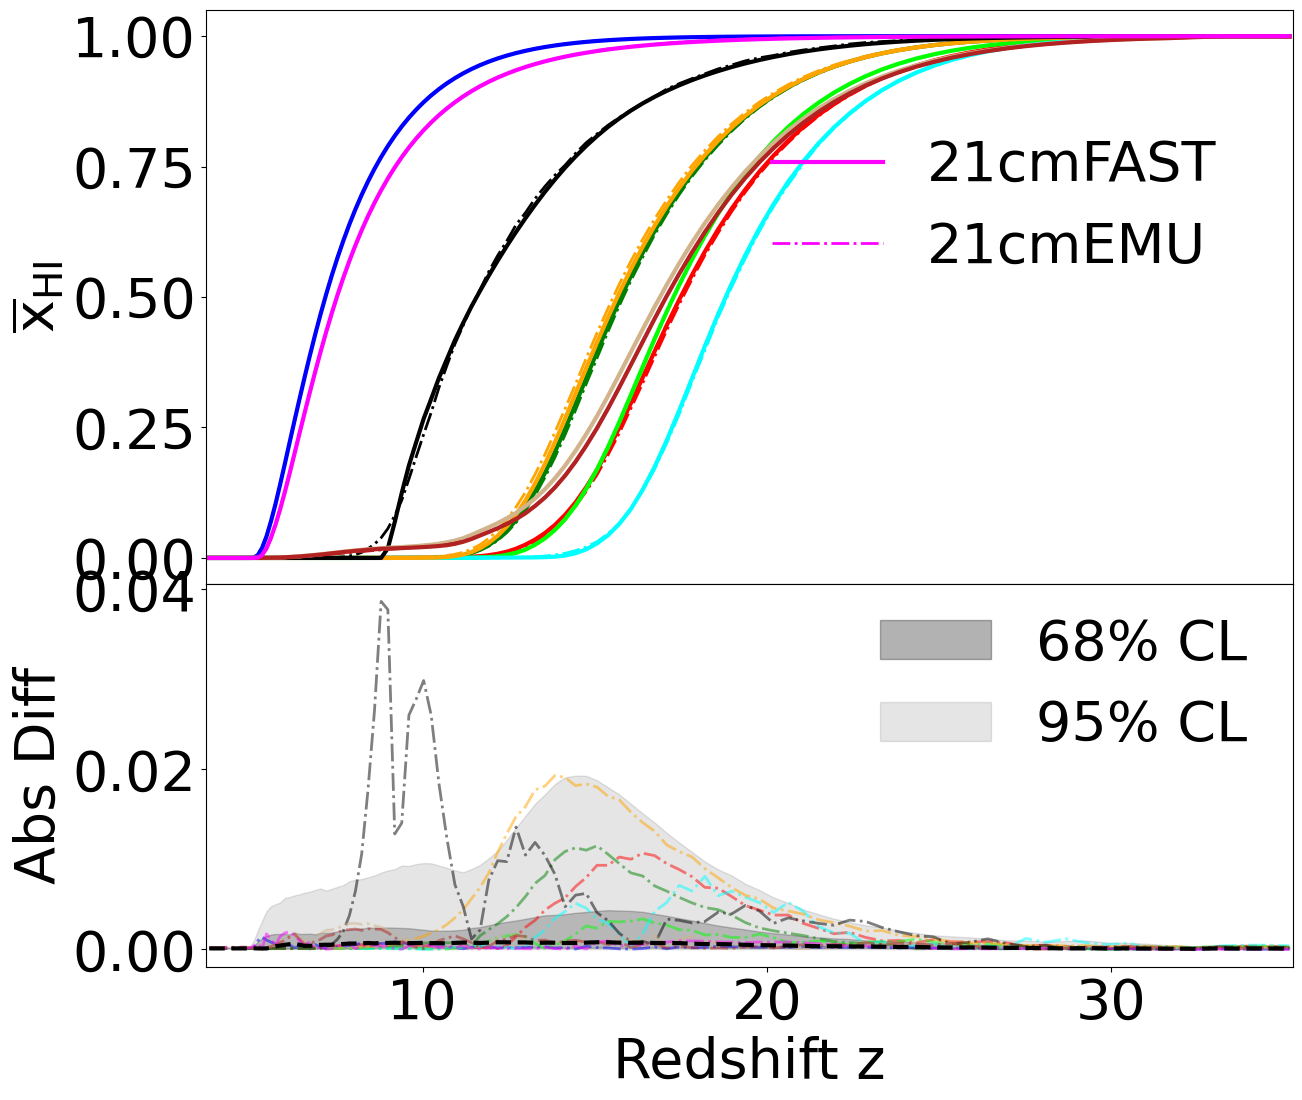

In [221]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

# inset axes...
# axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMU', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(zs, xHI_true[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, xHI_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    #axins.plot(zs, old_xHI_frac_err[i, :] * 100., ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, xHI_pred[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.5,0.5), frameon = False)#framealpha=0.3)
axs[1].plot(zs,diff_err_xHI_z[2, :], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_xHI_z[1, :], diff_err_xHI_z[3, :], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_xHI_z[0, :], diff_err_xHI_z[4, :], color = 'k', alpha = 0.1, label = r'95% CI')
#axins.plot(zs, err_xHI_z[1, :], ls = '--', lw = 3, color = 'k', label = r'$x_{\rm{HI}}$ Median')
#axins.fill_between(zs, err_xHI_z[0, :], err_xHI_z[2, :], color = 'k', alpha = 0.3, label = r'$x_{\rm{HI}}$ 68% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.5), frameon = False)
axs[0].set_ylabel(r'$\overline{\mathrm{x}}_{\rm{HI}}$')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')

plt.xlim(zs[0]-0.1, zs[-1]+0.1)

plt.tight_layout()
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/xHI_true_vs_emu_final.png', dpi = 300,  bbox_inches='tight')
plt.show()

In [38]:
ps_k[11]

0.10969735366408447

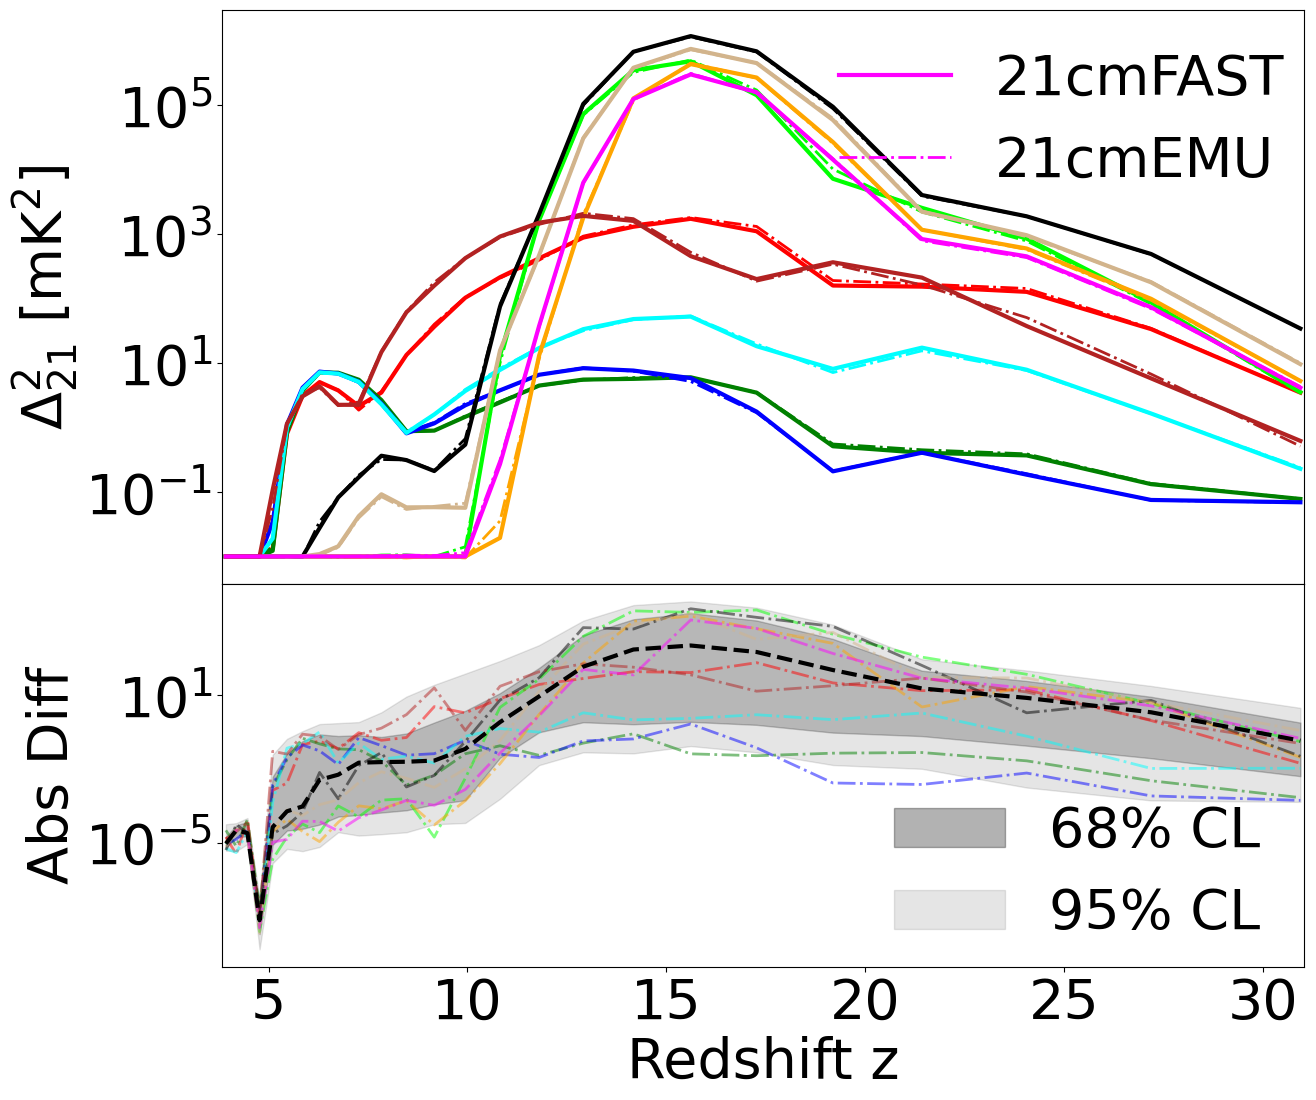

In [182]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

kbin = 11
# inset axes...
# axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMU', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(ps_z, PS_true[i, :, kbin], lw = 3, color = c, label = labels[1])
    axs[1].plot(ps_z, PS_diff[i, :, kbin], ls = '-.', alpha = 0.5, lw = 2, color = c)
    #axins.plot(zs, old_xHI_frac_err[i, :] * 100., ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(ps_z, PS_pred[i, :, kbin], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.55,0.65), frameon = False)#framealpha=0.3)
axs[1].plot(ps_z,diff_err_PS_z[2, :, kbin], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(ps_z, diff_err_PS_z[1, :, kbin], diff_err_PS_z[3, :, kbin], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(ps_z, diff_err_PS_z[0, :, kbin], diff_err_PS_z[4, :, kbin], color = 'k', alpha = 0.1, label = r'95% CI')
#axins.plot(zs, err_xHI_z[1, :], ls = '--', lw = 3, color = 'k', label = r'$x_{\rm{HI}}$ Median')
#axins.fill_between(zs, err_xHI_z[0, :], err_xHI_z[2, :], color = 'k', alpha = 0.3, label = r'$x_{\rm{HI}}$ 68% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.01), frameon = False)
axs[0].set_ylabel(r'$\Delta_{21}^2$ [mK$^2$]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

plt.xlim(ps_z[0]-0.1, ps_z[-1]+0.1)

plt.tight_layout()
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/xHI_true_vs_emu_final.png', dpi = 300,  bbox_inches='tight')
plt.show()

In [56]:
ps_z[11]

8.46594037485638

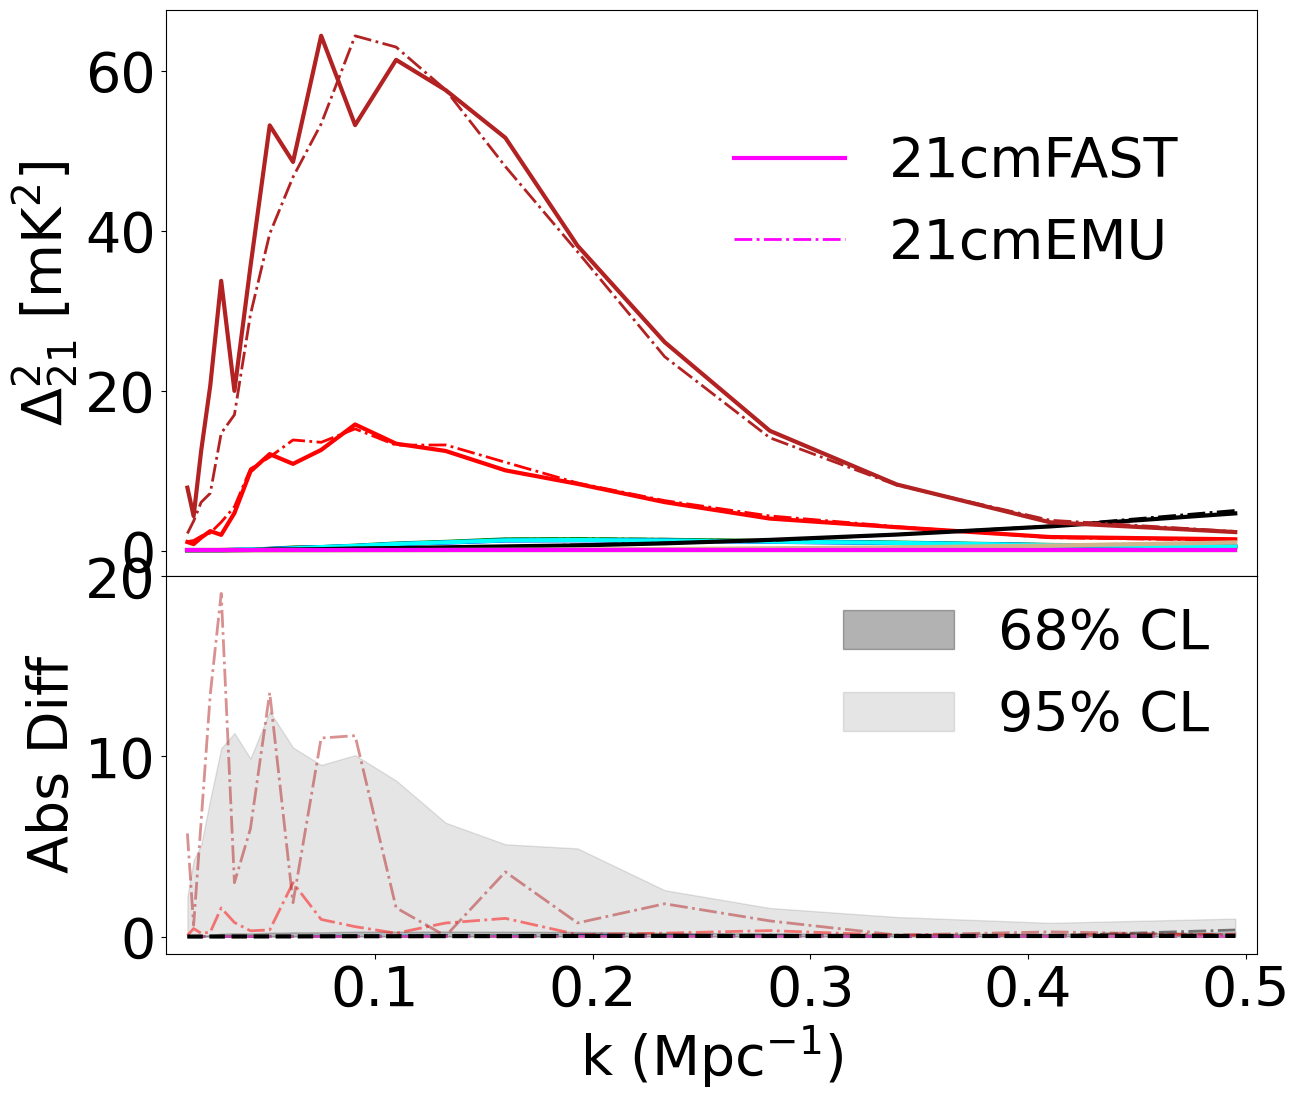

In [183]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

zbin = 11
# inset axes...
# axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMU', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(ps_k, PS_true[i, zbin,:], lw = 3, color = c, label = labels[1])
    axs[1].plot(ps_k, PS_diff[i, zbin,:], ls = '-.', alpha = 0.5, lw = 2, color = c)
    #axins.plot(zs, old_xHI_frac_err[i, :] * 100., ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(ps_k, PS_pred[i, zbin,:], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.5,0.5), frameon = False)#framealpha=0.3)
axs[1].plot(ps_k,diff_err_PS_z[2, zbin,:], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(ps_k, diff_err_PS_z[1, zbin,:], diff_err_PS_z[3, zbin,:], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(ps_k, diff_err_PS_z[0, zbin,:], diff_err_PS_z[4, zbin,:], color = 'k', alpha = 0.1, label = r'95% CI')
#axins.plot(zs, err_xHI_z[1, :], ls = '--', lw = 3, color = 'k', label = r'$x_{\rm{HI}}$ Median')
#axins.fill_between(zs, err_xHI_z[0, :], err_xHI_z[2, :], color = 'k', alpha = 0.3, label = r'$x_{\rm{HI}}$ 68% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.5), frameon = False)
axs[0].set_ylabel(r'$\Delta_{21}^2$ [mK$^2$]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'k (Mpc$^{-1}$)')

plt.xlim(ps_k[0]-1e-2, ps_k[-1]+1e-2)

plt.tight_layout()
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/xHI_true_vs_emu_final.png', dpi = 300,  bbox_inches='tight')
plt.show()

In [184]:
tau_bins = np.linspace(min(tau_true), np.percentile(tau_true, 99.9), 15)
tau_binned_fe = np.zeros(len(tau_bins))
tau_binned_fe_68 = np.zeros((len(tau_bins),2))
tau_binned_fe_95 = np.zeros((len(tau_bins),2))

In [185]:
for i in range(len(tau_bins)-1):
    mask = np.logical_and(tau_true >= tau_bins[i], tau_true < tau_bins[i+1])
    low1, low, med, high, high1 = (np.nanpercentile(tau_frac_err[mask], [2.5, 16,50,84, 97.5]))
    tau_binned_fe[i] = med
    tau_binned_fe_68[i,:] = [low, high]
    tau_binned_fe_95[i,:] = [low1, high1]

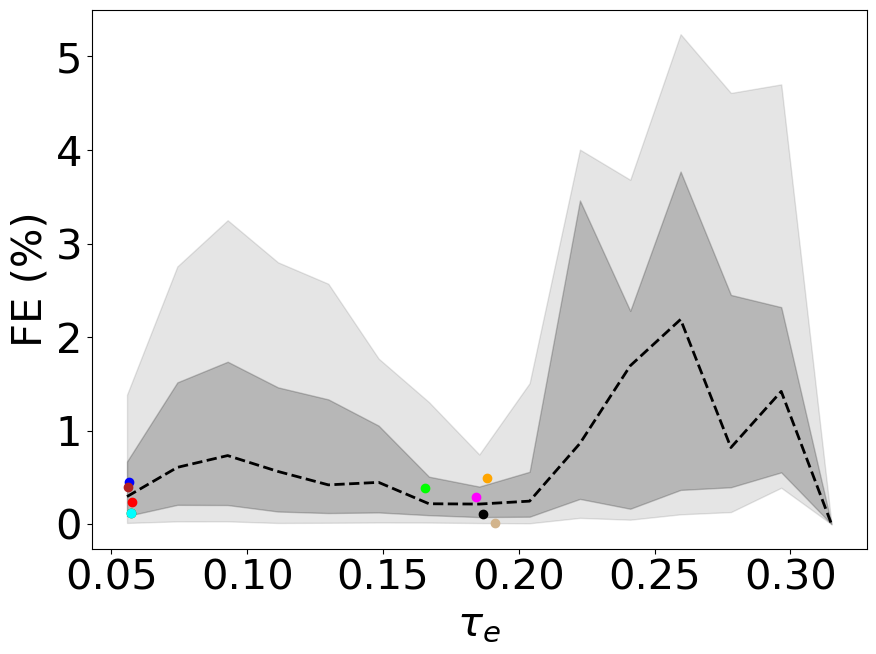

In [186]:
plt.figure(figsize=(10,7))
rcParams.update({'font.size': 30})
plt.plot(tau_bins, tau_binned_fe, color = 'k', lw = 2, ls = '--')
plt.fill_between(tau_bins, tau_binned_fe_68[:,0], tau_binned_fe_68[:,1], color = 'k', alpha = 0.2)
plt.fill_between(tau_bins, tau_binned_fe_95[:,0], tau_binned_fe_95[:,1], color = 'k', alpha = 0.1)

for i in range(N):
    plt.scatter(tau_pred[idxs[i]], tau_frac_err[idxs[i]], color = cs[i], marker = 'o', zorder = 2)
#plt.scatter(10**tau_true, tau_frac_err, alpha = 0.1)
plt.xlabel(r'$\tau_e$')
handles = [mpatches.Patch(color='k', label='68% CI', alpha = 0.1),
          mpatches.Patch(color='k', label='95% CI', alpha = 0.3),
          ]
#plt.legend(handles=handles, loc = (0.05,0.7), frameon = False, fontsize = 20)
plt.ylabel('FE (%)')
#plt.savefig('/home/dbreitman/ai4astro/New_emulator/Final_full_emulator_Jan24/Plotting/Plots/tau_binned.png', dpi = 300, bbox_inches = "tight")
plt.show()

In [227]:
# Test RadioEMU
import numpy as np
import sys
emu_path = '/home/dbreitman/Radio_Background/RadioEMU/src/'
sys.path.insert(1, emu_path)
import matplotlib.pyplot as plt
from radioemu import Emulator, properties

In [228]:
emulator = Emulator()

In [229]:
theta, out = emulator.predict(normed_params[:150,:])

In [230]:
np.max(abs(normed_params[:150,:] - theta))

0.0

In [231]:
out.PS_err[:,11]

array([9.07073057e-06, 3.14064889e-05, 2.41185100e-05, 6.91574479e-09,
       4.25112556e-05, 1.86866643e-04, 2.94492817e-04, 3.55406176e-03,
       5.75032234e-03, 1.77328499e-02, 1.87448062e-02, 1.93216652e-02,
       2.15787889e-02, 6.44502225e-02, 7.90458941e-01, 8.81008741e+00,
       1.42525040e+02, 7.10848831e+02, 1.03537136e+03, 5.63862201e+02,
       1.03901431e+02, 1.84878670e+01, 7.65754598e+00, 1.98885030e+00,
       1.39193060e-01])

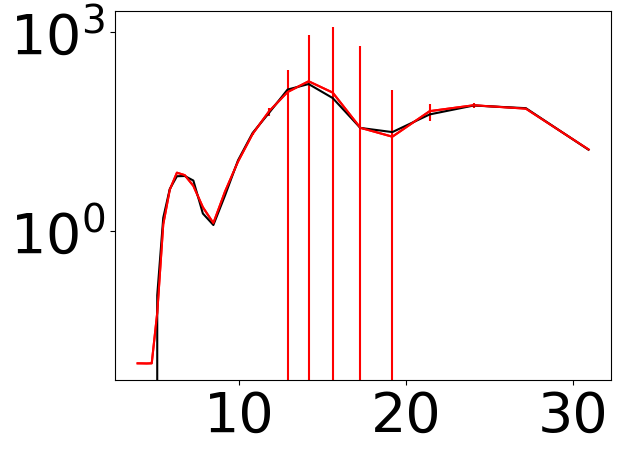

In [232]:
n=120
plt.plot(out.PS_redshifts, out.PS[n,:,11], color = 'r')
plt.errorbar(out.PS_redshifts, out.PS[n,:,11], yerr = out.PS_err[:,11], color = 'r')
plt.plot(out.PS_redshifts, ps[n,:,11], color = 'k')
plt.yscale('log')

In [2]:
import py21cmfast as p21

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [1]:
import astropy

In [19]:
foo = np.load("/home/dbreitman/Radio_Background/21CMMC/src/py21cmmc/data/HERA_H1C_IDR3.npz", allow_pickle=True)

In [30]:
foo["wfband8"].shape

(5, 16, 32)

In [23]:
foo["band8"][0,:,0]

array([0.22808842, 0.32412565, 0.42016288, 0.51620011, 0.61223734,
       0.70827458, 0.80431181, 0.90034904, 0.99638627, 1.0924235 ,
       1.18846073, 1.28449796, 1.38053519, 1.47657242, 1.57260965,
       1.66864688])

In [25]:
foo["kwfband8"]

array([0.18006981, 0.22808842, 0.27610704, 0.32412565, 0.37214427,
       0.42016288, 0.4681815 , 0.51620011, 0.56421873, 0.61223734,
       0.66025596, 0.70827458, 0.75629319, 0.80431181, 0.85233042,
       0.90034904, 0.94836765, 0.99638627, 1.04440488, 1.0924235 ,
       1.14044211, 1.18846073, 1.23647934, 1.28449796, 1.33251657,
       1.38053519, 1.4285538 , 1.47657242, 1.52459104, 1.57260965,
       1.62062827, 1.66864688])

In [13]:
foo = np.load("/home/dbreitman/new_HERA_data/HERA_H4C_IDR2p2.npz", allow_pickle=True)

In [17]:
foo["wfband8"].shape

(2, 20, 1)

In [15]:
foo["kwfband8"].shape

(20,)